# Model 1: Functional model of BLA
1. target behavioral data
    - conditioned fear reaponse
    - extinction-induced reduction of fear reaponse
    - renewal of fear reaponse when the CS is presented in the original context
2. target activity data
    - BLA fear neurons become CS-responsive after conditioning and lose CS-responsiveness after extinction
    - BLA extinction neurons become CS-responsive after extinction
    - BLA persistant neurons become CS-responsive after conditioning and maintain their activity after extinction

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from uniform_encoders import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = ScatteredHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # control signal to turn learning off
    def get_CS(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        self.CS = self.CSs[idx] if applied else np.zeros((self.dim_CS))
        return self.CS
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning
  

## Version 1: use PES learning to update connections weights from CS to BLA, such that BLA's CS response increases when the US is present alongside the CS

In [ ]:
dt = 0.001
nCond = 5
nExt = 10
seed = 0
nNeurons = 100
dim_CS = 3
dim_CTX = 5
nCS = 1
nCTX = 2
intercept_CS = 0
intercept_CTX = 0
lr = 1e-4  # learning_rate
rng = np.random.RandomState(seed=seed)
sampler = ScatteredHypersphere(surface=True)

inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)
encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
# intercepts_CS = nengo.dists.Uniform(-1, 1)
# intercepts_CTX = nengo.dists.Uniform(-1, 1)
dInh = -3e0*np.ones((nNeurons, 1))

In [28]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    BLA = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
    gate = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    fear = nengo.Ensemble(nNeurons, 1)  # [fear]
    # error ensembles
    error_CS_fear = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, gate[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, gate[1])
    # learned connections
    conditioning = nengo.Connection(external_CS, BLA[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
    nengo.Connection(external_US, BLA[1])
    # error connections
    nengo.Connection(BLA, error_CS_fear, function=lambda x: x[1]-x[0])  # US - (CS response)
    # error gating
    nengo.Connection(gate, error_CS_fear.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_CS_fear, conditioning.learning_rule, transform=-1)
    # output connections
    nengo.Connection(BLA[0], fear)  # CS response added to fear response
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pBLA_spikes = nengo.Probe(BLA.neurons)
    pBLA = nengo.Probe(BLA)
    pGate = nengo.Probe(gate)
    pError_CS_fear = nengo.Probe(error_CS_fear)
    pFear = nengo.Probe(fear)

In [29]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


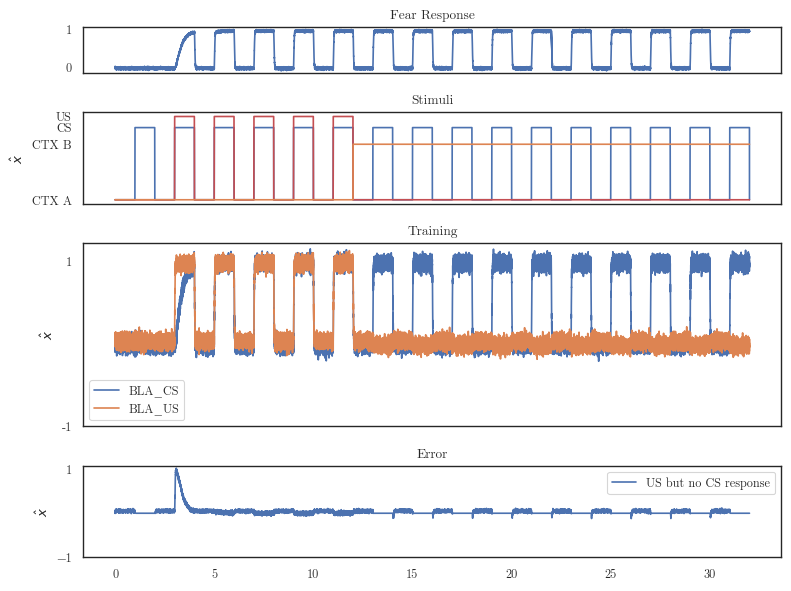

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,2,4,2]})
axes[0].plot(sim.trange(), sim.data[pFear])
axes[0].set(yticks=((0, 1)), ylabel=None, title="Fear Response")
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[pBLA][:,0], label="BLA_CS")
axes[2].plot(sim.trange(), sim.data[pBLA][:,1], label="BLA_US")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
axes[3].plot(sim.trange(), sim.data[pError_CS_fear], label="US but no CS response")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((-1,1)))
plt.tight_layout()

## Version 2: Use PES learning to update connection between CTX and BLA, such that BLA's CTX response decreases when the BLA's CS response is high but no US is present.

In [58]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
    # amygdala ensembles
    BLA = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
    gate = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    fear = nengo.Ensemble(nNeurons, 1)  # [fear]
    # error ensembles
    error_CS_fear = nengo.Ensemble(nNeurons, 1)
    error_CTX_safe = nengo.Ensemble(nNeurons, 1)

    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(CTX, external_CTX, synapse=None)
    nengo.Connection(external_CS, gate[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, gate[1])
    # learned connections
    conditioning = nengo.Connection(external_CS, BLA[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
    nengo.Connection(external_US, BLA[1])
    extinction = nengo.Connection(external_CTX, BLA[2], function=lambda x: 0, learning_rule_type=nengo.PES(0.2*lr))
    # error connections
    nengo.Connection(BLA, error_CS_fear, function=lambda x: x[1]-x[0])  # US - (CS response)
    nengo.Connection(BLA, error_CTX_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
    # error gating
    nengo.Connection(gate, error_CS_fear.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS
    nengo.Connection(gate, error_CTX_safe.neurons, function=lambda x: 1-x[0]+x[1], transform=dInh)  # inhibit by default; release if CS without US
    # error update
    nengo.Connection(error_CS_fear, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CTX_safe, extinction.learning_rule, transform=1)
    # output connections
    nengo.Connection(BLA[0], fear, transform=1)  # CS response added to fear response
    nengo.Connection(BLA[2], fear, transform=1)  # CTX response added to fear response

    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pBLA_spikes = nengo.Probe(BLA.neurons)
    pBLA = nengo.Probe(BLA)
    pError_CS_fear = nengo.Probe(error_CS_fear)
    pError_CTX_safe = nengo.Probe(error_CTX_safe)
    pFear = nengo.Probe(fear)

In [59]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


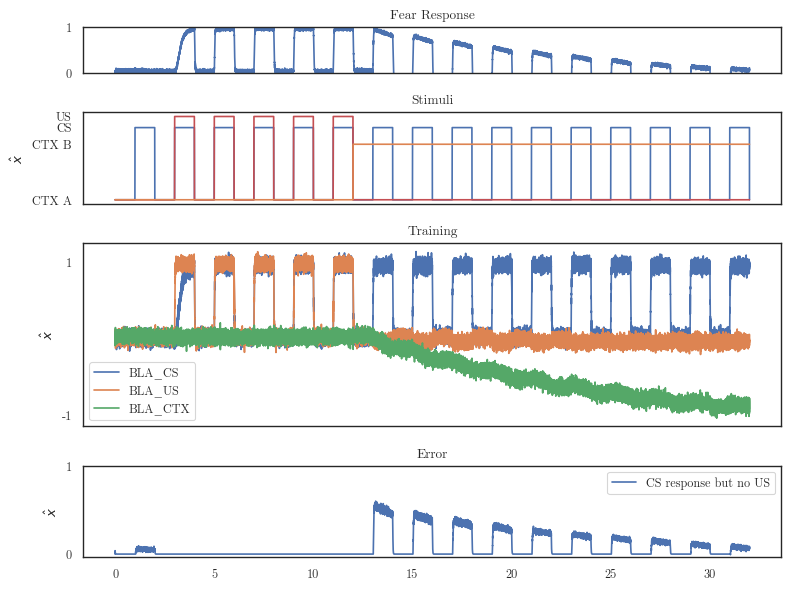

In [60]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,2,4,2]})
axes[0].plot(sim.trange(), sim.data[pFear])
axes[0].set(yticks=((0, 1)), ylim=((0,1)), ylabel=None, title="Fear Response")
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[pBLA][:,0], label="BLA_CS")
axes[2].plot(sim.trange(), sim.data[pBLA][:,1], label="BLA_US")
axes[2].plot(sim.trange(), sim.data[pBLA][:,2], label="BLA_CTX")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
# axes[3].plot(sim.trange(), sim.data[pError_CS_fear], label="US but no CS response")
axes[3].plot(sim.trange(), sim.data[pError_CTX_safe], label="CS response but no US")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

## Version 3: Use PES learning to update connection between CTX and BLA, such that BLA's CTX response increases when the US is present, but decreases when the US is absent

In [3]:
def build_network(
        dt = 0.001,
        nCond = 5,
        nExt = 10,
        seed = 0,
        nNeurons = 100,
        dim_CS = 3,
        dim_CTX = 5,
        nCS = 1,
        nCTX = 3,
        intercept_CS = 0,
        intercept_CTX = 0,
        lr = 1e-4,
    ):

    rng = np.random.RandomState(seed=seed)
    sampler = ScatteredHypersphere(surface=True)
    inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)
    encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
    encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
    intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
    intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
    dInh = -3e0*np.ones((nNeurons, 1))

    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.01
    net.config[nengo.Probe].synapse = 0.01

    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
        # amygdala ensembles
        BLA = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        gate = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        fear = nengo.Ensemble(nNeurons, 1)  # [fear]

        # error ensembles
        error_CS_fear = nengo.Ensemble(nNeurons, 1)
        error_CTX_fear = nengo.Ensemble(nNeurons, 1)
        error_CTX_safe = nengo.Ensemble(nNeurons, 1)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(CTX, external_CTX, synapse=None)
        nengo.Connection(external_CS, gate[0], function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, gate[1]) 
        # learned connections
        conditioning = nengo.Connection(external_CS, BLA[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
        nengo.Connection(external_US, BLA[1])
        extinction = nengo.Connection(external_CTX, BLA[2], function=lambda x: 0, learning_rule_type=nengo.PES(0.2*lr))
        # error connections
        nengo.Connection(BLA, error_CS_fear, function=lambda x: x[1]-x[0])  # US - (CS response)
        nengo.Connection(BLA, error_CTX_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
        nengo.Connection(BLA, error_CTX_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
        # error gating
        nengo.Connection(gate, error_CS_fear.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS
        nengo.Connection(gate, error_CTX_safe.neurons, function=lambda x: 1-x[0]+x[1], transform=dInh)  # inhibit by default; release if CS without US
        nengo.Connection(gate, error_CTX_fear.neurons, function=lambda x: 1-x[1], transform=0.4*dInh)  # slow learning unless US
        # error update
        nengo.Connection(error_CS_fear, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CTX_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_CTX_fear, extinction.learning_rule, transform=-1)
        # prevent learning during testing
        nengo.Connection(stop_learning, error_CS_fear.neurons, transform=dInh)
        nengo.Connection(stop_learning, error_CTX_safe.neurons, transform=dInh)
        nengo.Connection(stop_learning, error_CTX_fear.neurons, transform=dInh)
        # output connections
        nengo.Connection(BLA[0], fear, transform=0.5)  # CS response added to fear response
        nengo.Connection(BLA[2], fear, transform=0.5)  # CTX response added to fear response

        # probes
        pCS = nengo.Probe(CS, synapse=None)
        pUS = nengo.Probe(US, synapse=None)
        pCTX = nengo.Probe(CTX, synapse=None)
        pBLA_spikes = nengo.Probe(BLA.neurons)
        pBLA = nengo.Probe(BLA)
        pError_CS_fear = nengo.Probe(error_CS_fear)
        pError_CTX_fear = nengo.Probe(error_CTX_fear)
        pError_CTX_safe = nengo.Probe(error_CTX_safe)
        pFear = nengo.Probe(fear)
        
        # reference
        net.inputs = inputs
        net.pCS = pCS
        net.pUS = pUS
        net.pCTX = pCTX
        net.pBLA_spikes = pBLA_spikes
        net.pBLA = pBLA
        net.pError_CS_fear = pError_CS_fear
        net.pError_CTX_fear = pError_CTX_fear
        net.pError_CTX_safe = pError_CTX_safe
        net.pFear = pFear
        
    return net

## Version 3 supports many forms of context conditioning and extinction
- ABB (control) vs ABA (renewal test) vs ABC (novel test)
- CS conditioning (CS-US pairing): AA (control) vs AB (renewal test)
- context conditioning (US only); AA (safe context) vs AB (new context)

### Fear conditioning in context A (CS+ and CTX+ paired with US), then fear extinction in context B (CS+ and CTX- paired with NO US). Comparison test is fear response to CS+ in context A, B, or C

In [5]:
nCond = 5
nExt = 10

net = build_network(nCond=nCond, nExt=nExt)
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    net.inputs.stop_learning = 0
    print("control")
    net.inputs.CTX = net.inputs.CTXs[0]
    sim.run(2)
    T1a = int(1/dt)
    T1b = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2a = int((2+2*nCond-1)/dt)
    T2b = int((2+2*nCond)/dt)
    print("extinction")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    T3a = int((2+2*nCond+2*nExt-1)/dt)
    T3b = int((2+2*nCond+2*nExt)/dt)
    print("turn learning off for testing")
    net.inputs.stop_learning = 1
    print("test CTX A")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T4a = int((2+2*nCond+2*nExt+1)/dt)
    T4b = int((2+2*nCond+2*nExt+2)/dt)
    print("test CTX B")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    sim.run(2)
    T5a = int((2+2*nCond+2*nExt+2+1)/dt)
    T5b = int((2+2*nCond+2*nExt+2+2)/dt)  
    print("test CTX C")
    net.inputs.CTX = net.inputs.CTXs[2]
    net.inputs.US = 0
    sim.run(2)
    T6a = int((2+2*nCond+2*nExt+2+2+1)/dt)
    T6b = int((2+2*nCond+2*nExt+2+2+2)/dt)  

/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/nengo/cache.py:610: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  "Decoder cache could not acquire lock and was "


control
conditioning
extinction
turn learning off for testing
test CTX A
test CTX B
test CTX C


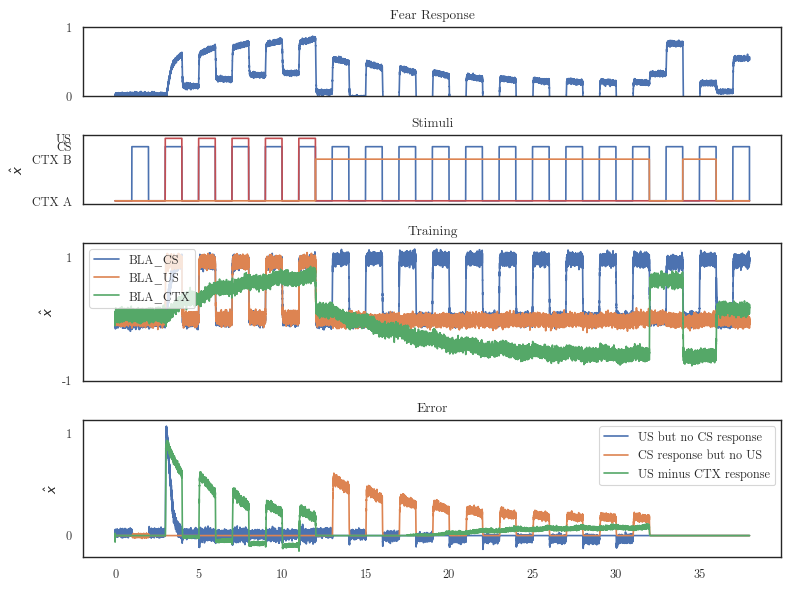

In [110]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
axes[0].plot(sim.trange(), sim.data[net.pFear])
axes[0].set(yticks=((0, 1)), ylim=((0,1)), ylabel=None, title="Fear Response")
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[net.pUS], label="US", c='r')
ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[net.pBLA][:,0], label="BLA_CS")
axes[2].plot(sim.trange(), sim.data[net.pBLA][:,1], label="BLA_US")
axes[2].plot(sim.trange(), sim.data[net.pBLA][:,2], label="BLA_CTX")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
axes[3].plot(sim.trange(), sim.data[net.pError_CS_fear], label="US but no CS response")
axes[3].plot(sim.trange(), sim.data[net.pError_CTX_safe], label="CS response but no US")
axes[3].plot(sim.trange(), sim.data[net.pError_CTX_fear], label="US minus CTX response")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

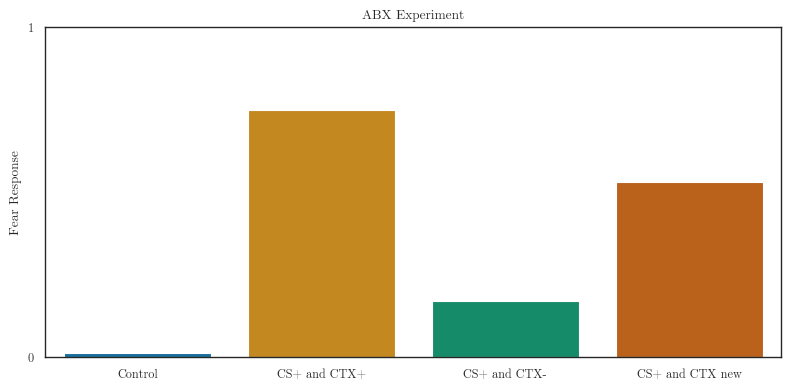

In [117]:
data = pd.DataFrame(columns=["Fear Response", "Experiment"])
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T1a: T1b]),
    "Experiment": "Control"},
    ignore_index=True)
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T4a: T4b]),
    "Experiment": "CS+ and CTX+"},
    ignore_index=True)
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T5a: T5b]),
    "Experiment": "CS+ and CTX-"},
    ignore_index=True)
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T6a: T6b]),
    "Experiment": "CS+ and CTX new"},
    ignore_index=True)

fig, ax = plt.subplots(figsize=((8,4)))
sns.barplot(data=data, x='Experiment', y="Fear Response", palette=palette)
ax.set(title="ABX Experiment", xlabel=None, yticks=((0,1)))
plt.tight_layout()

### Fear conditioning in context A (CS+ paired with US), then fear extinction in context A (CS+ paired with NO US). Comparison test is fear response to CS+ in context A or B

In [118]:
nCond = 5
nExt = 10

net = build_network(nCond=nCond, nExt=nExt)
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    net.inputs.stop_learning = 0
    print("control")
    net.inputs.CTX = net.inputs.CTXs[0]
    sim.run(2)
    T1a = int(1/dt)
    T1b = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2a = int((2+2*nCond-1)/dt)
    T2b = int((2+2*nCond)/dt)
    print("extinction")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    T3a = int((2+2*nCond+2*nExt-1)/dt)
    T3b = int((2+2*nCond+2*nExt)/dt)
    print("turn learning off for testing")
    net.inputs.stop_learning = 1
    print("test CTX A")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T4a = int((2+2*nCond+2*nExt+1)/dt)
    T4b = int((2+2*nCond+2*nExt+2)/dt)
    print("test CTX B")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    sim.run(2)
    T5a = int((2+2*nCond+2*nExt+2+1)/dt)
    T5b = int((2+2*nCond+2*nExt+2+2)/dt)  

control
conditioning
extinction
turn learning off for testing
test CTX A
test CTX B


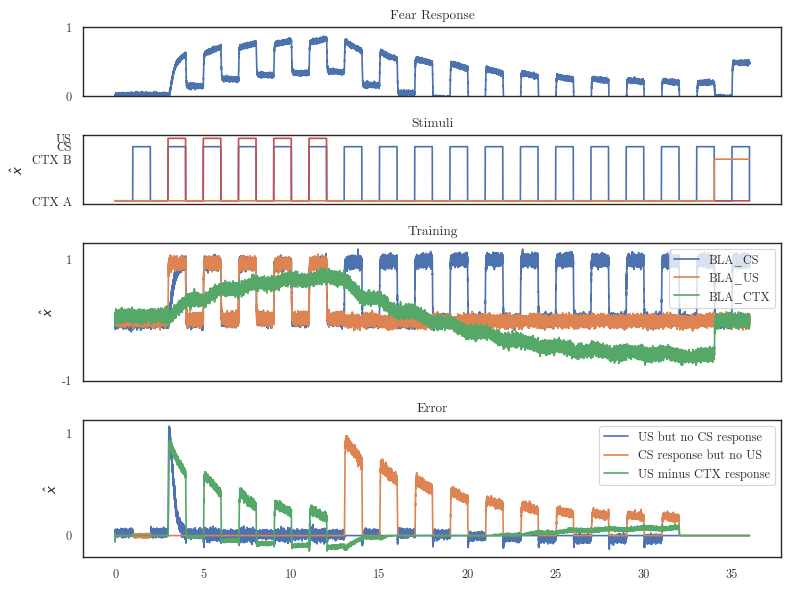

In [119]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
axes[0].plot(sim.trange(), sim.data[net.pFear])
axes[0].set(yticks=((0, 1)), ylim=((0,1)), ylabel=None, title="Fear Response")
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[net.pUS], label="US", c='r')
ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[net.pBLA][:,0], label="BLA_CS")
axes[2].plot(sim.trange(), sim.data[net.pBLA][:,1], label="BLA_US")
axes[2].plot(sim.trange(), sim.data[net.pBLA][:,2], label="BLA_CTX")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
axes[3].plot(sim.trange(), sim.data[net.pError_CS_fear], label="US but no CS response")
axes[3].plot(sim.trange(), sim.data[net.pError_CTX_safe], label="CS response but no US")
axes[3].plot(sim.trange(), sim.data[net.pError_CTX_fear], label="US minus CTX response")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

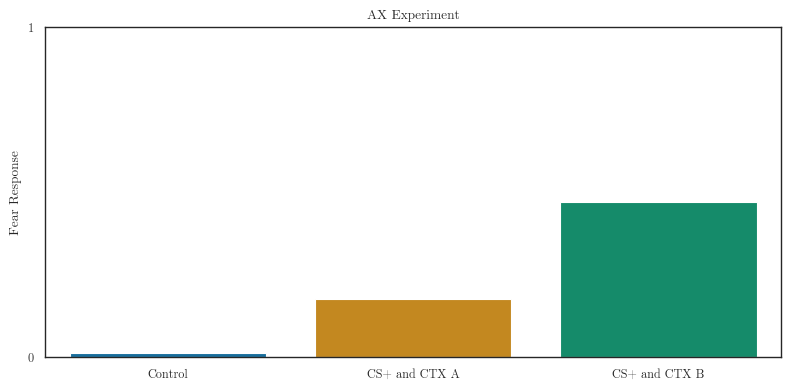

In [120]:
data = pd.DataFrame(columns=["Fear Response", "Experiment"])
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T1a: T1b]),
    "Experiment": "Control"},
    ignore_index=True)
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T4a: T4b]),
    "Experiment": "CS+ and CTX A"},
    ignore_index=True)
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T5a: T5b]),
    "Experiment": "CS+ and CTX B"},
    ignore_index=True)

fig, ax = plt.subplots(figsize=((8,4)))
sns.barplot(data=data, x='Experiment', y="Fear Response", palette=palette)
ax.set(title="AX Experiment", xlabel=None, yticks=((0,1)))
plt.tight_layout()

### Context conditioning (CTX+ paired with US), then fear extinction (CTX- paired with NO US). Comparison test is fear response in CTX+ vs CTX-

In [124]:
nCond = 5
nExt = 10

net = build_network(nCond=nCond, nExt=nExt)
net.inputs.CSs = 0 * net.inputs.CSs  # turn off CS
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    net.inputs.stop_learning = 0
    print("control")
    net.inputs.CTX = net.inputs.CTXs[0]
    sim.run(2)
    T1a = int(1/dt)
    T1b = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2a = int((2+2*nCond-1)/dt)
    T2b = int((2+2*nCond)/dt)
    print("extinction")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    T3a = int((2+2*nCond+2*nExt-1)/dt)
    T3b = int((2+2*nCond+2*nExt)/dt)
    print("turn learning off for testing")
    net.inputs.stop_learning = 1
    print("test CTX A")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 0
    sim.run(2)
    T4a = int((2+2*nCond+2*nExt+1)/dt)
    T4b = int((2+2*nCond+2*nExt+2)/dt)
    print("test CTX B")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    sim.run(2)
    T5a = int((2+2*nCond+2*nExt+2+1)/dt)
    T5b = int((2+2*nCond+2*nExt+2+2)/dt)  

control
conditioning
extinction
turn learning off for testing
test CTX A
test CTX B


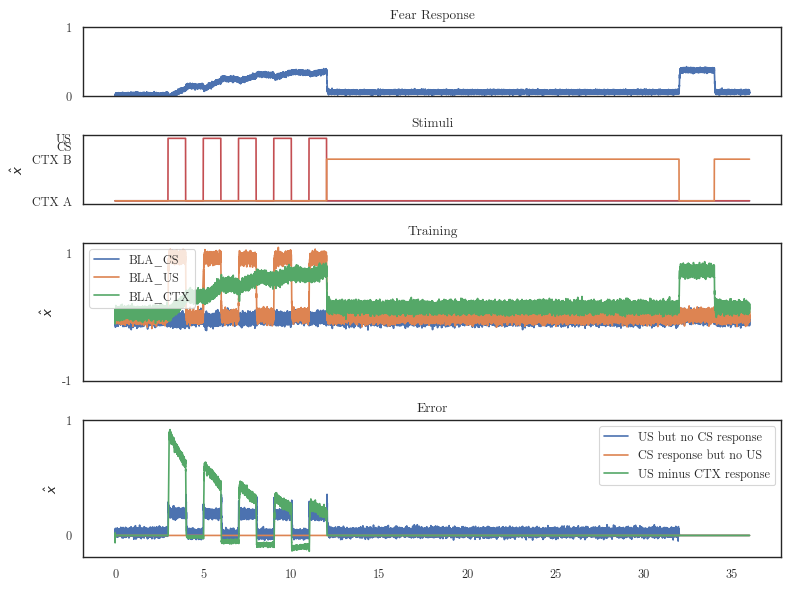

In [125]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
axes[0].plot(sim.trange(), sim.data[net.pFear])
axes[0].set(yticks=((0, 1)), ylim=((0,1)), ylabel=None, title="Fear Response")
axes[1].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.5*sim.data[net.pUS], label="US", c='r')
ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[net.pBLA][:,0], label="BLA_CS")
axes[2].plot(sim.trange(), sim.data[net.pBLA][:,1], label="BLA_US")
axes[2].plot(sim.trange(), sim.data[net.pBLA][:,2], label="BLA_CTX")
axes[2].legend()
axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
axes[3].plot(sim.trange(), sim.data[net.pError_CS_fear], label="US but no CS response")
axes[3].plot(sim.trange(), sim.data[net.pError_CTX_safe], label="CS response but no US")
axes[3].plot(sim.trange(), sim.data[net.pError_CTX_fear], label="US minus CTX response")
axes[3].legend()
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()

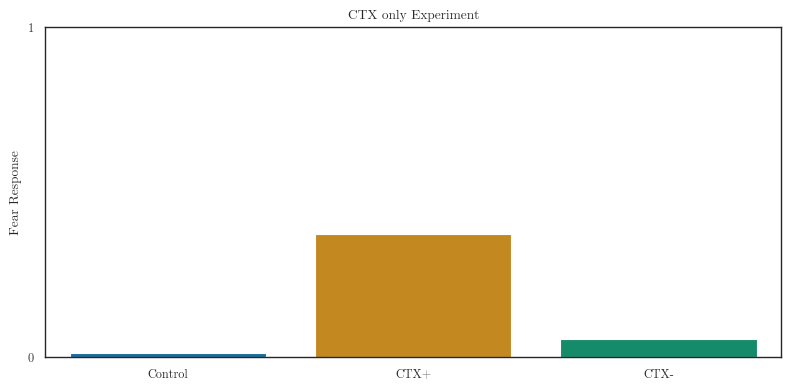

In [126]:
data = pd.DataFrame(columns=["Fear Response", "Experiment"])
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T1a: T1b]),
    "Experiment": "Control"},
    ignore_index=True)
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T4a: T4b]),
    "Experiment": "CTX+"},
    ignore_index=True)
data = data.append({
    "Fear Response": np.mean(sim.data[net.pFear][T5a: T5b]),
    "Experiment": "CTX-"},
    ignore_index=True)

fig, ax = plt.subplots(figsize=((8,4)))
sns.barplot(data=data, x='Experiment', y="Fear Response", palette=palette)
ax.set(title="CTX only Experiment", xlabel=None, yticks=((0,1)))
plt.tight_layout()

## Version 3 contains fear neurons, extinction neurons, and persistent neurons

In [6]:
nCond = 5
nExt = 10

net = build_network(nCond=nCond, nExt=nExt)
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    net.inputs.stop_learning = 0
    print("control")
    net.inputs.CTX = net.inputs.CTXs[0]
    sim.run(2)
    T1a = int(1/dt)
    T1b = int(2/dt)
    print("conditioning")
    net.inputs.CTX = net.inputs.CTXs[0]
    net.inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    T2a = int((2+2*nCond-1)/dt)
    T2b = int((2+2*nCond)/dt)
    print("extinction")
    net.inputs.CTX = net.inputs.CTXs[1]
    net.inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    T3a = int((2+2*nCond+2*nExt-1)/dt)
    T3b = int((2+2*nCond+2*nExt)/dt)

control
conditioning
extinction


24.3% of BLA neurons are 'fear neurons'
32.0% of BLA neurons are 'extinction neurons'
34.7% of BLA neurons are 'persistent neurons'


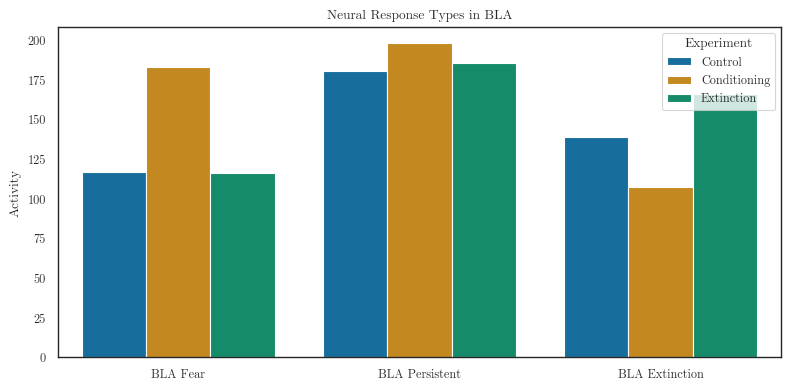

In [19]:
aControl_BLA = sim.data[net.pBLA_spikes][T1a: T1b]
aConditioning_BLA = sim.data[net.pBLA_spikes][T2a: T2b]
aExtinction_BLA = sim.data[net.pBLA_spikes][T3a: T3b]   

fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > np.mean(aControl_BLA, axis=0))[0]
fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < np.mean(aConditioning_BLA, axis=0))[0]
fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > np.mean(aConditioning_BLA, axis=0))[0]
persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

data_activity = pd.DataFrame(columns=["Type", "Activity", "Experiment"])
data_activity = data_activity.append({"Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"Type": "BLA Persistent", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"Type": "BLA Persistent", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"Type": "BLA Persistent", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"Type": "BLA Extinction", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"Type": "BLA Extinction", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"Type": "BLA Extinction", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Experiment": "Extinction"}, ignore_index=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(title="Neural Response Types in BLA", xlabel=None)
plt.tight_layout()

print(f"{len(fear_neurons)/(3*nNeurons)*100:.3}% of BLA neurons are 'fear neurons'")
print(f"{len(extinction_neurons)/(3*nNeurons)*100:.3}% of BLA neurons are 'extinction neurons'")
print(f"{len(persistent_neurons)/(3*nNeurons)*100:.3}% of BLA neurons are 'persistent neurons'")

## Run many network seeds for version 3 and compare fear responses and neural activities

In [10]:
def run(data_fear, data_activity, data_counts, seed=0, learning_rate=1e-4, dt=1e-3, nNeurons=100):
    
    print(f"seed = {seed}")
    nCond = 5
    nExt = 10

    net = build_network(nCond=nCond, nExt=nExt, seed=seed, nNeurons=nNeurons)
    sim = nengo.Simulator(net, dt=dt, progress_bar=False)
    with sim:
        net.inputs.stop_learning = 0
#         print("control")
        net.inputs.CTX = net.inputs.CTXs[0]
        sim.run(2)
        T1a = int(1/dt)
        T1b = int(2/dt)
#         print("conditioning")
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 1
        for p in range(nCond):
            sim.run(2)
        T2a = int((2+2*nCond-1)/dt)
        T2b = int((2+2*nCond)/dt)
#         print("extinction")
        net.inputs.CTX = net.inputs.CTXs[1]
        net.inputs.US = 0
        for p in range(nExt):
            sim.run(2)
        T3a = int((2+2*nCond+2*nExt-1)/dt)
        T3b = int((2+2*nCond+2*nExt)/dt)
#         print("turn learning off for testing")
        net.inputs.stop_learning = 1
#         print("test CTX A")
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 0
        sim.run(2)
        T4a = int((2+2*nCond+2*nExt+1)/dt)
        T4b = int((2+2*nCond+2*nExt+2)/dt)
#         print("test CTX B")
        net.inputs.CTX = net.inputs.CTXs[1]
        net.inputs.US = 0
        sim.run(2)
        T5a = int((2+2*nCond+2*nExt+2+1)/dt)
        T5b = int((2+2*nCond+2*nExt+2+2)/dt)  
#         print("test CTX C")
        net.inputs.CTX = net.inputs.CTXs[2]
        net.inputs.US = 0
        sim.run(2)
        T6a = int((2+2*nCond+2*nExt+2+2+1)/dt)
        T6b = int((2+2*nCond+2*nExt+2+2+2)/dt)  

    data_fear = data_fear.append({
        "Fear Response": np.mean(sim.data[net.pFear][T1a: T1b]),
        "Experiment": "Control"},
        ignore_index=True)
    data_fear = data_fear.append({
        "Fear Response": np.mean(sim.data[net.pFear][T4a: T4b]),
        "Experiment": "CS+ and CTX+"},
        ignore_index=True)
    data_fear = data_fear.append({
        "Fear Response": np.mean(sim.data[net.pFear][T5a: T5b]),
        "Experiment": "CS+ and CTX-"},
        ignore_index=True)
    data_fear = data_fear.append({
        "Fear Response": np.mean(sim.data[net.pFear][T6a: T6b]),
        "Experiment": "CS+ and CTX new"},
        ignore_index=True)

    aControl_BLA = sim.data[net.pBLA_spikes][T1a: T1b]
    aConditioning_BLA = sim.data[net.pBLA_spikes][T2a: T2b]
    aExtinction_BLA = sim.data[net.pBLA_spikes][T3a: T3b]   

    fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > np.mean(aControl_BLA, axis=0))[0]
    fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < np.mean(aConditioning_BLA, axis=0))[0]
    fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
    extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > np.mean(aConditioning_BLA, axis=0))[0]
    persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

    data_activity = data_activity.append({
        "seed": seed,
        "Type": "BLA Fear",
        "Activity": np.mean(aControl_BLA[:,fear_neurons]),
        "Experiment": "Control"},
        ignore_index=True)
    data_activity = data_activity.append({
        "seed": seed,
        "Type": "BLA Fear",
        "Activity": np.mean(aConditioning_BLA[:,fear_neurons]),
        "Experiment": "Conditioning"},
        ignore_index=True)
    data_activity = data_activity.append({
        "seed": seed,
        "Type": "BLA Fear",
        "Activity": np.mean(aExtinction_BLA[:,fear_neurons]),
        "Experiment": "Extinction"},
        ignore_index=True)
    data_activity = data_activity.append({
        "seed": seed,
        "Type": "BLA Persistent",
        "Activity": np.mean(aControl_BLA[:,persistent_neurons]),
        "Experiment": "Control"},
        ignore_index=True)
    data_activity = data_activity.append({
        "seed": seed,
        "Type": "BLA Persistent",
        "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]),
        "Experiment": "Conditioning"},
        ignore_index=True)
    data_activity = data_activity.append({
        "seed": seed,
        "Type": "BLA Persistent",
        "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]),
        "Experiment": "Extinction"},
        ignore_index=True)
    data_activity = data_activity.append({
        "seed": seed,
        "Type": "BLA Extinction",
        "Activity": np.mean(aControl_BLA[:,extinction_neurons]),
        "Experiment": "Control"},
        ignore_index=True)
    data_activity = data_activity.append({
        "seed": seed,
        "Type": "BLA Extinction",
        "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]),
        "Experiment": "Conditioning"},
        ignore_index=True)
    data_activity = data_activity.append({
        "seed": seed,
        "Type": "BLA Extinction",
        "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]),
        "Experiment": "Extinction"},
        ignore_index=True)

    percent_fear = len(fear_neurons)/(3*nNeurons)*100
    percent_extinction = len(extinction_neurons)/(3*nNeurons)*100
    percent_persistent = len(persistent_neurons)/(3*nNeurons)*100
    data_counts = data_counts.append({
        "seed": seed,
        "Type":"Fear",
        "Percent": percent_fear}, ignore_index=True)
    data_counts = data_counts.append({
        "seed": seed,
        "Type":"Extinction",
        "Percent": percent_extinction}, ignore_index=True)
    data_counts = data_counts.append({
        "seed": seed,
        "Type":"Persistent",
        "Percent": percent_persistent}, ignore_index=True)

    return data_fear, data_activity, data_counts

In [11]:
def model1_experiment(seeds):
    data_fear = pd.DataFrame(columns=["seed", "Fear Response", "Experiment"])
    data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
    data_counts = pd.DataFrame(columns=["seed", "Type", "Percent"])

    rng = np.random.RandomState(seeds)
    for s in range(seeds):
        data_fear, data_activity, data_counts = run(
            data_fear, data_activity, data_counts, seed=s, learning_rate=rng.uniform(3e-5, 3e-4))

    data_fear.to_pickle("model1_data_fear.pkl")
    data_activity.to_pickle("model1_data_activity.pkl")
    data_counts.to_pickle("model1_data_counts.pkl")

    fig, ax = plt.subplots(figsize=((8,4)))
    sns.barplot(data=data_fear, x='Experiment', y="Fear Response", palette=palette)
    ax.set(title="Conditioning, Extinction, and Renewal", xlabel=None, yticks=((0,1)))
    plt.tight_layout()

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
    sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
    ax.set(title="Neural Response Types in BLA", xlabel=None)
    plt.tight_layout()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((8,4)), sharey=True)
    sns.histplot(data=data_counts.query("Type=='Fear'")['Percent'], bins=10, ax=axes[0])
    sns.histplot(data=data_counts.query("Type=='Persistent'")['Percent'], bins=10, ax=axes[1])
    sns.histplot(data=data_counts.query("Type=='Extinction'")['Percent'], bins=10, ax=axes[2])
    axes[0].set(title="Fear Neurons")
    axes[1].set(title="Persistent Neurons")
    axes[2].set(title="Extinction Neurons")
    plt.tight_layout()

seed = 0
seed = 1
seed = 2
seed = 3
seed = 4
seed = 5
seed = 6
seed = 7
seed = 8
seed = 9


/home/pduggins/amygdala/.venv/lib/python3.7/site-packages/nengo/cache.py:610: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  "Decoder cache could not acquire lock and was "


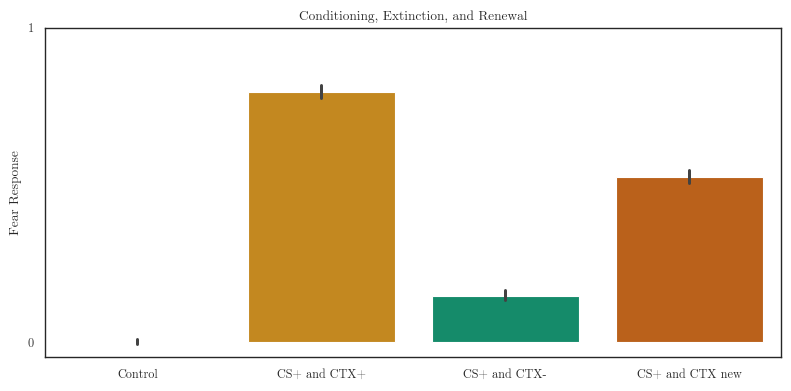

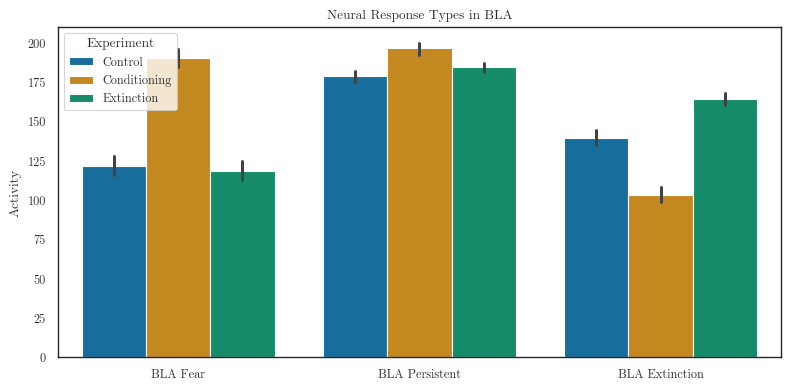

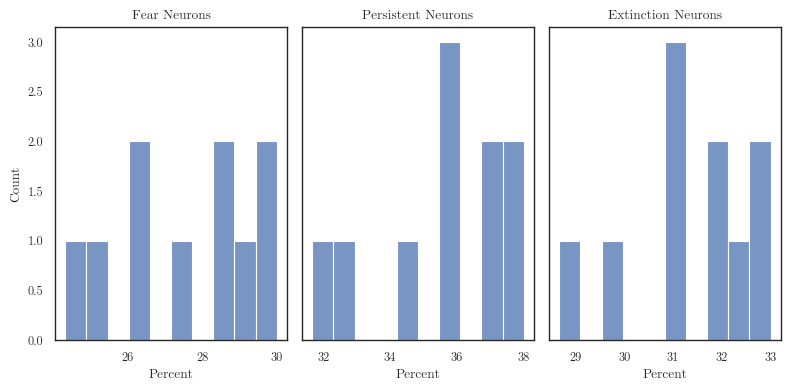

In [12]:
model1_experiment(seeds=10)